In [109]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/Users/rdgao/Documents/code/research/fooof/')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/SpaceRecon/')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')

import matplotlib.pylab as plt
import numpy as np
import scipy as sp
from scipy import io
import os
from scv_funcs import access_nt, utils
import neurodsp as ndsp
from nlds import dfa, delayembed

# Import the FOOOF object
from fooof import FOOOF, FOOOFGroup

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Raw data processing

In [335]:
do_compute_psds = True
do_compute_spg = False
do_compute_dfas = False
do_fooof_psds = False

data_path = '/Users/rdgao/Documents/data/NeuroTycho/'
datasets = ['Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128',
           'Propofol/20120731PF_Anesthesia+and+Sleep_George_Toru+Yanagawa_mat_ECoG128',
           'Propofol/20120802PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128',
           'Propofol/20120803PF_Anesthesia+and+Sleep_George_Toru+Yanagawa_mat_ECoG128',
            'Ketamine/20120719KT_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128',
            'Ketamine/20120724KT_Anesthesia+and+Sleep_George_Toru+Yanagawa_mat_ECoG128',
            'Ketamine/20120810KT_Anesthesia+and+Sleep_George_Toru+Yanagawa_mat_ECoG128',
            'Ketamine/20120813KT_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128'            
           ]
sess_append = '/Session%d/'

session_indices = [(1,0,1), (1,2,3), (2,0,1), (2,1,2)]
session_labels = ['EyesOpen', 'EyesClosed', 'Delivery', 'Anesthesia']

for ds in datasets:    
    print('------\n',ds)
    for i in range(len(session_indices)):
        session = session_indices[i]
        outfile = str(i)+'_'+(session_labels[i]+'_'+ds).replace('/','_').replace('+','_')
        print(outfile)
        
        indices = access_nt.get_cond(data_path+ds+sess_append,session[0], session[1], session[2])
        data = access_nt.get_ECoG(data_path+ds+sess_append, session[0], range(1,129), indices)
        fs = 1000.
        
        # compute PSDs
        psd_path = data_path+'results/psd/'
        if do_compute_psds:    
            # 1 second resolution psd
            full_outpath = psd_path+'1sec_win/'
            if not os.path.exists(full_outpath):
                os.makedirs(full_outpath)
            print(full_outpath)
            nperseg, noverlap, flim, spg_outlierpct = int(fs), int(fs/2), 200., 5
            f_axis, psd_full = ndsp.spectral.psd(data, fs, method='mean', nperseg=nperseg, noverlap=noverlap, flim=flim)
            f_axis, psd = ndsp.spectral.psd(data, fs, method='mean', nperseg=nperseg, noverlap=noverlap, flim=flim, spg_outlierpct=spg_outlierpct)
            f_axis, psd_med = ndsp.spectral.psd(data, fs, method='median', nperseg=nperseg, noverlap=noverlap, flim=flim, spg_outlierpct=spg_outlierpct)
            save_dict = dict((name,eval(name)) for name in ['f_axis','psd','psd_full','psd_med','nperseg','noverlap','fs','spg_outlierpct'])
            np.savez(file=full_outpath+outfile+'.npz', **save_dict)
            
            # 10 second resolution psd
            full_outpath = psd_path+'10sec_win/'
            if not os.path.exists(full_outpath):
                os.makedirs(full_outpath)
            print(full_outpath)
            nperseg, noverlap, flim, spg_outlierpct = int(fs*10), int(fs*5), 200., 5
            f_axis, psd_full = ndsp.spectral.psd(data, fs, method='mean', nperseg=nperseg, noverlap=noverlap, flim=flim)
            f_axis, psd = ndsp.spectral.psd(data, fs, method='mean', nperseg=nperseg, noverlap=noverlap, flim=flim, spg_outlierpct=spg_outlierpct)
            f_axis, psd_med = ndsp.spectral.psd(data, fs, method='median', nperseg=nperseg, noverlap=noverlap, flim=flim, spg_outlierpct=spg_outlierpct)
            save_dict = dict((name,eval(name)) for name in ['f_axis','psd','psd_full','psd_med','nperseg','noverlap','fs','spg_outlierpct'])
            np.savez(file=full_outpath+outfile+'.npz', **save_dict)
        
        if do_compute_spg:
            # compute rolling psd
            full_outpath = psd_path+'1sec_rolling/'
            if not os.path.exists(full_outpath):
                os.makedirs(full_outpath)
            print(full_outpath)
            nperseg, noverlap, winlen_roll = int(fs), int(fs/2), 10.
            f_axis, t_roll, psd_rolling, psd_rolling_med=compute_rolling_psd(data, fs, nperseg=nperseg, noverlap=noverlap, winlen_roll=winlen_roll)            
            np.savez(file=full_outpath+outfile+'.npz', f_axis=f_axis, t_roll=t_roll, psd_rolling=psd_rolling, psd_rolling_med=psd_rolling_med,nperseg=nperseg, noverlap=noverlap, fs=fs, winlen_roll=winlen_roll)
        
        # compute DFA
        dfa_path = data_path+'results/dfa/'
        if do_compute_dfas:
            print(dfa_path)
            if not os.path.exists(dfa_path):
                os.makedirs(dfa_path)

            t_scales, DFs, alphas = compute_dfa(data, fs, dfa_n_scales=20, dfa_min_scale=0.01, dfa_max_scale=10)
            np.savez(file=dfa_path+outfile, t_scales=t_scales, DFs=DFs, alphas=alphas)

------
 Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128
0_EyesOpen_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128
AwakeEyesOpened-Start to AwakeEyesOpened-End
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/
1_EyesClosed_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128
AwakeEyesClosed-Start to AwakeEyesClosed-End
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/
2_Delivery_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128
AnestheticInjection to Anesthetized-Start
Handling run-time error: Did not fully consume compressed contents of an miCOMPRESSED element. This can indicate that the .mat file is corrupted.
Channel 63 is filled in with white noise.
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/
/Users/rdgao/Documents/data/NeuroTycho

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/
1_EyesClosed_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128
AwakeEyesClosed-Start to AwakeEyesClosed-End
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/
2_Delivery_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128
AnestheticInjection to Anesthetized-Start
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/
3_Anesthesia_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128
Anesthetized-Start to Anesthetized-End
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/


# FOOOF PSDs & plot

In [359]:
# 1 sec fooof
do_plot = True
if do_plot:
    plt.figure(figsize=(4,4))

fooof_range = (2,70)
psd_path = '/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/'
psd_files = sorted([pf for pf in os.listdir(psd_path) if '.npz' in pf])
for pf in psd_files:    
    full_outpath = psd_path+'fooof/'
    if not os.path.exists(full_outpath):
        os.makedirs(full_outpath)
    print(full_outpath+pf)
    psd_data = np.load(psd_path+pf)

    # plot
    if do_plot: plot_psds(psd_data, psd_path, pf)

    # fooof    
    bg, pks, ftns, bg_kn, pks_kn, ftns_kn = fooof_psd(psd_data['f_axis'], psd_data['psd'], fooof_range=fooof_range)
    bg_med, pks_med, ftns_med, bg_kn_med, pks_kn_med, ftns_kn_med = fooof_psd(psd_data['f_axis'], psd_data['psd_med'], fooof_range=fooof_range)
    
    save_dict = dict((name,eval(name)) for name in ['bg','pks','ftns','bg_kn','pks_kn','ftns_kn','bg_med','pks_med','ftns_med','bg_kn_med','pks_kn_med','ftns_kn_med', 'fooof_range'])
    np.savez(full_outpath+pf, **save_dict)

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/0_EyesOpen_Ketamine_20120719KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/0_EyesOpen_Ketamine_20120724KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/0_EyesOpen_Ketamine_20120810KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/0_EyesOpen_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/0_EyesOpen_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/0_EyesOpen_Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/0_EyesO

/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/0_EyesOpen_Propofol_20120803PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/1_EyesClosed_Ketamine_20120719KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/1_EyesClosed_Ketamine_20120724KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/1_EyesClosed_Ketamine_20120810KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/1_EyesClosed_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/1_EyesClosed_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/1_EyesClosed_Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/f

/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/2_Delivery_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/2_Delivery_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/2_Delivery_Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/2_Delivery_Propofol_20120802PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/2_Delivery_Propofol_20120803PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/3_Anesthesia_Ketamine_20120719KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/3_Anesthesia_Ketamine_20120724KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/3_Anesthesia_Ketamine_20120810KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/3_Anesthesia_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/3_Anesthesia_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/3_Anesthesia_Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/3_Anesthesia_Propofol_20120802PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/fooof/3_Anesthesia_Propofol_20120803PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

In [360]:
# 10 sec fooof
do_plot = True
if do_plot:
    plt.figure(figsize=(4,4))

fooof_range = (0.2,70)
psd_path = '/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/'
psd_files = sorted([pf for pf in os.listdir(psd_path) if '.npz' in pf])
for pf in psd_files:    
    full_outpath = psd_path+'fooof/'
    if not os.path.exists(full_outpath):
        os.makedirs(full_outpath)
    print(full_outpath+pf)
    psd_data = np.load(psd_path+pf)

    # plot
    if do_plot: plot_psds(psd_data, psd_path, pf)

    # fooof    
    bg, pks, ftns, bg_kn, pks_kn, ftns_kn = fooof_psd(psd_data['f_axis'], psd_data['psd'], fooof_range=fooof_range)
    bg_med, pks_med, ftns_med, bg_kn_med, pks_kn_med, ftns_kn_med = fooof_psd(psd_data['f_axis'], psd_data['psd_med'], fooof_range=fooof_range)
    
    save_dict = dict((name,eval(name)) for name in ['bg','pks','ftns','bg_kn','pks_kn','ftns_kn','bg_med','pks_med','ftns_med','bg_kn_med','pks_kn_med','ftns_kn_med', 'fooof_range'])
    np.savez(full_outpath+pf, **save_dict)

/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/0_EyesOpen_Ketamine_20120719KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/0_EyesOpen_Ketamine_20120724KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/0_EyesOpen_Ketamine_20120810KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/0_EyesOpen_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/0_EyesOpen_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/0_EyesOpen_Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/0_EyesOpen_Propofol_20120802PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/0_EyesOpen_Propofol_20120803PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/1_EyesClosed_Ketamine_20120719KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/1_EyesClosed_Ketamine_20120724KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/1_EyesClosed_Ketamine_20120810KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/1_EyesClosed_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/1_EyesClosed_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/1_EyesClosed_Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/1_EyesClosed_Propofol_20120802PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/1_EyesClosed_Propofol_20120803PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/2_Delivery_Ketamine_20120719KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/2_Delivery_Ketamine_20120724KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/2_Delivery_Ketamine_20120810KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/2_Delivery_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/2_Delivery_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Doc

/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/2_Delivery_Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/2_Delivery_Propofol_20120802PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/2_Delivery_Propofol_20120803PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/3_Anesthesia_Ketamine_20120719KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/3_Anesthesia_Ketamine_20120724KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/3_Anesthesia_Ketamine_20120810KT_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/3_Anesthesia_Ketamine_20120813KT_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/3_Anesthesia_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz
/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/3_Anesthesia_Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/3_Anesthesia_Propofol_20120802PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


/Users/rdgao/Documents/data/NeuroTycho/results/psd/10sec_win/fooof/3_Anesthesia_Propofol_20120803PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz


/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/Users/rdgao/Documents/code/research/fooof/fooof/core/funcs.py:65: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


In [195]:
def compute_rolling_psd(data, fs, nperseg, noverlap, winlen_roll, f_lim=200.):
    """
    winlen_roll: float
        rolling window length in seconds
    """
    numchan = data.shape[0]

    f_axis, t_axis, spg = sp.signal.spectrogram(data, fs, nperseg=nperseg, noverlap=noverlap)
    win_roll = int(winlen_roll/(1-noverlap/nperseg))
    t_roll = np.array([ts[0] for ts in utils.yield_sliding_window_ts(t_axis, win_roll, 0)])
    
    psd_rolling = np.zeros((numchan, len(f_axis), len(t_roll)))
    psd_rolling_med = np.zeros((numchan, len(f_axis), len(t_roll)))
    for chan in range(numchan):
        psd_rolling[chan,:,:] = np.array([chunk.mean(axis=-1) for chunk in utils.yield_sliding_window_ts(spg[chan], win_roll, 0)]).T
        psd_rolling_med[chan,:,:] = np.array([np.median(chunk,axis=-1) for chunk in utils.yield_sliding_window_ts(spg[chan], win_roll, 0)]).T

    f_ind = np.where(f_axis>f_lim)[0][0]
    return f_axis[:f_ind], t_roll, psd_rolling[:,:f_ind,:], psd_rolling_med[:,:f_ind,:]

In [357]:
def plot_psds(psd_data, psd_folder, sessionfile):
    numchan = psd_data['psd_full'].shape[0]
    full_outpath = psd_folder+'/psd_plot/'+sessionfile.split('.')[0]
    if not os.path.exists(full_outpath):
        os.makedirs(full_outpath)

    for chan in range(numchan):
        plt.loglog(psd_data['f_axis'], psd_data['psd_full'][chan,:], 'k-', label='Welch')
        plt.loglog(psd_data['f_axis'], psd_data['psd'][chan,:], 'b-', label='Welch %i%% Outlier'%psd_data['spg_outlierpct'])
        plt.loglog(psd_data['f_axis'], psd_data['psd_med'][chan,:], 'r-', label='MWelch %i%% Outlier'%psd_data['spg_outlierpct'])
        plt.legend()
        plt.title('Channel: %i'%chan)
        plt.xlabel('Frequency (Hz)')
        plt.tight_layout()        
        plt.savefig(full_outpath+'/chan%i.png'%chan)
        plt.clf()

In [91]:
def compute_dfa(data, fs, dfa_n_scales=10, dfa_min_scale=0.01, dfa_max_scale=10):
    numchan=data.shape[0]
    DFs = np.zeros((numchan,dfa_n_scales))
    alphas = np.zeros(numchan)
    for chan in range(numchan):
        # compute DFA
        t_scales, DFs[chan,:], alphas[chan] = dfa.dfa(data[chan,:],fs, dfa_n_scales, dfa_min_scale, dfa_max_scale)

    return t_scales, DFs, alphas

In [210]:
def fooof_psd(f_axis, psds, fooof_range=(2,70), max_n_peaks=3):
    # FOOOF PSDs without knee
    fg = FOOOFGroup(background_mode='fixed', max_n_peaks=max_n_peaks, verbose=False)
    fg.fit(freqs=f_axis, power_spectra=psds, freq_range=fooof_range)

    bg = fg.get_all_data('background_params')
    pks = [f.peak_params for f in fg]
    ftns = np.array([fg.get_all_data('r_squared'),fg.get_all_data('error')]).T

    # FOOOF PSDs with knee
    fg_kn = FOOOFGroup(background_mode = 'knee', max_n_peaks=5, verbose=False)
    fg_kn.fit(freqs=f_axis, power_spectra=psds, freq_range=fooof_range)

    bg_kn = fg_kn.get_all_data('background_params')
    pks_kn = [f.peak_params for f in fg_kn]
    ftns_kn = np.array([fg_kn.get_all_data('r_squared'),fg_kn.get_all_data('error')]).T
    
    return bg, pks, ftns, bg_kn, pks_kn, ftns_kn



def fooof_spg(f_axis, spg, fooof_range=(2,70), max_n_peaks=5):
    # fooof 3D psd [chan x freq x time/slice]
    
    # FOOOF PSDs without knee
    fg = FOOOFGroup(background_mode='fixed', max_n_peaks=max_n_peaks, verbose=False)
    bg, pks, ftns = [],[],[]
    for t in range(spg.shape[2]):
        fg.fit(freqs=f_axis, power_spectra=spg[:,:,t], freq_range=fooof_range)
        bg.append(fg.get_all_data('background_params'))
        pks.append([f.peak_params for f in fg])
        ftns.append(np.array([fg.get_all_data('r_squared'),fg.get_all_data('error')]).T)

    # FOOOF PSDs with knee
    fg_kn = FOOOFGroup(background_mode = 'knee', max_n_peaks=max_n_peaks, verbose=False)
    bg_kn, pks_kn, ftns_kn = [],[],[]
    for t in range(spg.shape[2]):
        fg_kn.fit(freqs=f_axis, power_spectra=spg[:,:,t], freq_range=fooof_range)
        bg_kn.append(fg_kn.get_all_data('background_params'))
        pks_kn.append([f.peak_params for f in fg_kn])
        ftns_kn.append(np.array([fg_kn.get_all_data('r_squared'),fg_kn.get_all_data('error')]).T)
        
    return bg, pks, ftns, bg_kn, pks_kn, ftns_kn

In [ ]:
# def compute_psds(data, fs, nperseg, noverlap, winlen_roll, f_lim=200.):
#     """
#     winlen_roll: float
#         rolling window length in seconds
#     """
#     numchan = data.shape[0]

#     # 1-sec PSD
#     f_axis, t_axis, spg = sp.signal.spectrogram(data, fs, nperseg=nperseg, noverlap=noverlap)
#     psd = spg.mean(axis=-1)
#     psd_med = spg.median(axis=-1)

#     # 1-sec rolling PSD
#     win_roll = int(winlen_roll/(1-noverlap/nperseg))
#     t_roll = np.array([ts[0] for ts in utils.yield_sliding_window_ts(t_axis, win_roll, 0)])
#     psd_rolling = np.zeros((numchan, len(f_axis1), len(t_roll)))
#     psd_m_rolling = np.zeros((numchan, len(f_axis1), len(t_roll)))
#     for chan in range(numchan):
#         psd_rolling[chan,:,:] = np.array([chunk.mean(axis=-1) for chunk in utils.yield_sliding_window_ts(spg[chan], win_roll, 0)]).T

#     # 10-sec PSD
#     f_axis_L, psd_L = ndsp.spectral.psd(data, fs, nperseg=nperseg*10, noverlap=nperseg*5)
#     f_axis_L, psd_L_med = ndsp.spectral.psd(data, fs, method='median', nperseg=nperseg*10, noverlap=nperseg*5)
    
#     f_ind = np.where(f_axis>f_lim)[0][0]
#     f_L_ind = np.where(f_axis_L>f_lim)[0][0]
#     return f_axis[:f_ind], psd[:,:f_ind], t_roll, psd_rolling[:,:f_ind,:], f_axis_L[:f_L_ind], psd_L[:,:f_L_ind]

In [95]:
# def compute_nonlinear(data, fs, ac_max_lag=1000, dfa_n_scales=10, dfa_min_scale=0.01, dfa_max_scale=10, de_max_tau=1000, de_max_dim=5):
#     numchan=data.shape[0]
#     ACs = np.zeros((numchan,ac_max_lag))
#     DFs = np.zeros((numchan,dfa_n_scales))
#     alphas = np.zeros(numchan)
#     dMIs = np.zeros((numchan,de_max_tau))
#     tau_MI = np.zeros(numchan)
#     pfnns = np.zeros((numchan, de_max_dim))
#     recon_dims = np.zeros(numchan)    
#     for chan in range(numchan):
#         print('AC')
#         # compute autocorr
#         t_ac, ACs[chan,:] = delayembed.autocorr(data[chan,:],max_lag=ac_max_lag)
#         print('DFA')
#         # compute DFA
#         t_scales, DFs[chan,:], alphas[chan] = dfa.dfa(data[chan,:],fs, dfa_n_scales, dfa_min_scale, dfa_max_scale)

#         # compute MI 
#         print('MI')
#         tMI, dMIs[chan,:] = delayembed.compute_delay_MI(data[chan,:],50,de_max_tau)
#         opt_delay = delayembed.find_valley(dMIs[chan,:])
#         tau_MI[chan] = opt_delay[0]
        
#         print('DE')
#         # compute delay-embedding pfnn
#         recon_dims[chan], pfnns[chan,:] = delayembed.pfnn_de_dim(data[chan,:],tau=opt_delay[0],max_dim=de_max_dim)

#     return ACs, t_scales, DFs, alphas, dMIs, tau_MI, pfnns, recon_dims

In [ ]:
# def compute_features(data, fs, fooof_range=(2,200), ac_max_lag=500, dfa_n_scales=10, dfa_min_scale=0.01, dfa_max_scale=1):
#     n_chans = data.shape[0]
#     # compute PSDs
#     f_axis, PSD = ndsp.spectral.psd(data,fs)
#     PSD=PSD.T

#     # FOOOF PSDs without knee
#     fg = FOOOFGroup(max_n_peaks=0)
#     fg.fit(freqs=f_axis, power_spectra=PSD.T, freq_range=fooof_range)
#     fit_slope_lin = fg.get_all_data('background_params', 'slope')
    
#     # FOOOF PSDs with knee
#     fg_kn = FOOOFGroup(background_mode = 'knee', max_n_peaks=0)
#     fg_kn.fit(freqs=f_axis, power_spectra=PSD.T, freq_range=fooof_range)
#     fit_knee = fg_kn.get_all_data('background_params', 'knee')
#     fit_slope_kn = fg_kn.get_all_data('background_params', 'slope')

#     # compute power at knee frequency
#     P_knee = [PSD[np.argmin(np.abs((f_axis-(fit_knee[i]**0.5)))),i] for i in range(n_chans)]

#     # compute autocorrelation & DFA
#     AC = []
#     DF = []
#     alphas = np.zeros(n_chans)
#     for i in range(n_chans):
#         t_ac, ac = de.autocorr(data[i,:],max_lag=ac_max_lag)
#         AC.append(ac)
#         t_scales, df, alphas[i] = dfa.dfa(data[i,:],fs, dfa_n_scales, dfa_min_scale, dfa_max_scale)
#         DF.append(df)
    
#     AC = np.array(AC)
#     DF = np.array(DF)    
#     return f_axis, PSD, fit_slope_lin, fit_slope_kn, fit_knee, P_knee, t_ac, AC, t_scales, DF, alphas

In [269]:
indices = access_nt.get_cond(data_path+datasets[0]+sess_append,session[0], session[1], session[2])
data = access_nt.get_ECoG(data_path+datasets[0]+sess_append, session[0], range(1,129), indices)


AwakeEyesOpened-Start to AwakeEyesOpened-End


In [184]:
None is not None

False

In [190]:
f_axis, psd = ndsp.spectral.psd(data[:3,:], fs, nperseg=1000, noverlap=500)
f_axis, psd_med = ndsp.spectral.psd(data[:3,:], fs, method='median', nperseg=1000, noverlap=500)

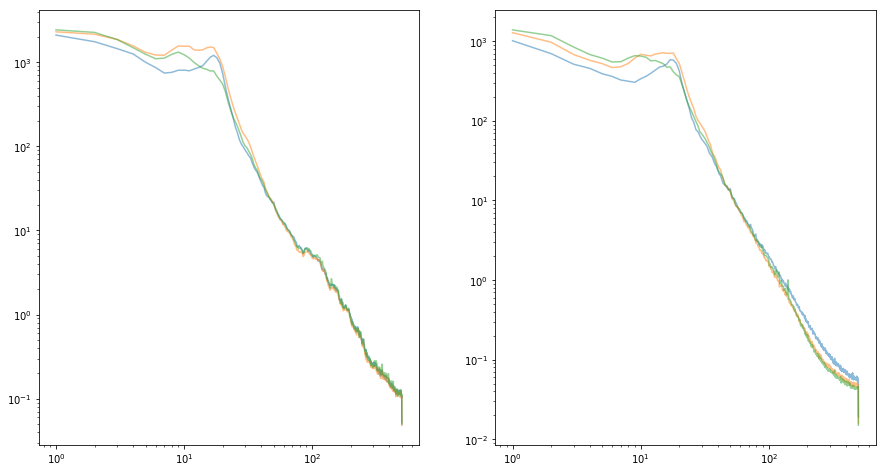

In [191]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.loglog(f_axis,psd.T, alpha=0.5);

plt.subplot(1,2,2)
plt.loglog(f_axis,psd_med.T, alpha=0.5);

In [152]:
fg = FOOOFGroup(background_mode='knee', max_n_peaks=5, verbose=False)
fg.fit(freqs=f_axis, power_spectra=psd, freq_range=(2,70))
welch_fit = fg.get_all_data('background_params')
fg.fit(freqs=f_axis, power_spectra=psd_med, freq_range=(2,70))
medw_fit = fg.get_all_data('background_params')

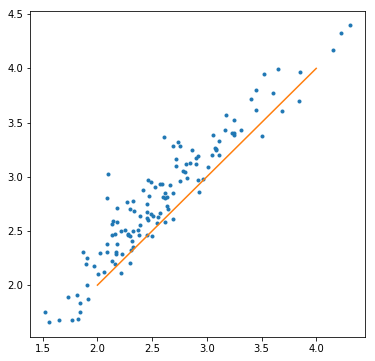

In [162]:
plt.figure(figsize=(6,6))
plt.plot(welch_fit[:,2], medw_fit[:,2], '.')
plt.plot([2,4], [2,4])

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


array([ 10,  18,   1,   5,  19,   9, 122, 121,  31,  25,   3,  13,   6,
        43,  29, 120,  17,  95,   0, 110,   8,  12,  24,  27,  32,  15,
        39, 114,  28,  70,   2,  37,  11,  16,  26,  71,  61,  83,  14,
        33,  97,  73,  57,  23,  22,  84, 115,  20, 108,  82,  40,  72,
       107, 119,  81,   4,  42,  85,  69,  98, 124,  36, 125,  38,  99,
        94, 104,  86,  80, 116,  68,  91,  34,  41,  74, 117,  93,  30,
       109, 113,  90,  52,  67,  54, 111,  62,  64,  58, 126,  53,  89,
        66,  21, 106,  96, 118,  76,  78,  56, 103,  92, 112, 102,  77,
        44,  79,  50,  51,  88, 127,  45,  65,  35, 101,  55,  49,  87,
        60,  59,  63,   7,  46,  47,  75, 100,  48, 123, 105])

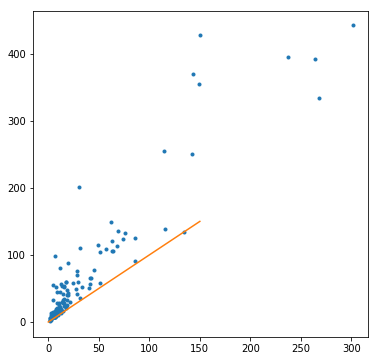

In [163]:
plt.figure(figsize=(6,6))
plt.plot(welch_fit[:,1]**0.5, medw_fit[:,1]**0.5, '.')
plt.plot([0,150], [0,150])
np.argsort(welch_fit[:,1]**0.5-medw_fit[:,1]**0.5)

30.00326221890188 200.90051685362988


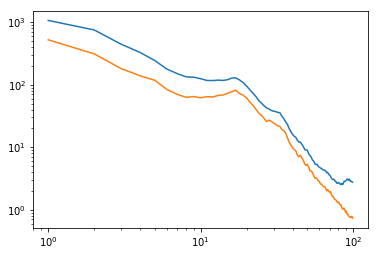

In [170]:
chan = 5
print(welch_fit[chan,1]**0.5, medw_fit[chan,1]**0.5)
plt.loglog(f_axis[:100], psd[chan,:100])
plt.loglog(f_axis[:100], psd_med[chan,:100])

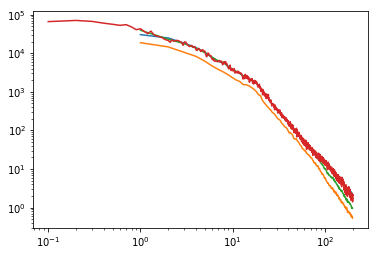

In [334]:
psd_test = np.load('/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/0_EyesOpen_Propofol_20120731PF_Anesthesia_and_Sleep_George_Toru_Yanagawa_mat_ECoG128.npz')
psd_test = np.load('/Users/rdgao/Documents/data/NeuroTycho/results/psd/1sec_win/0_EyesOpen_Propofol_20120730PF_Anesthesia_and_Sleep_Chibi_Toru_Yanagawa_mat_ECoG128.npz')
chan=100
plt.loglog(psd_test['f_axis'], psd_test['psd'][chan,:]);
plt.loglog(psd_test['f_axis'], psd_test['psd_med'][chan,:]);
plt.loglog(lf.f_axis, lf.psd[chan,:])
plt.loglog(f_axis, psd[chan,:])

In [287]:
indices = access_nt.get_cond(data_path+datasets[0]+sess_append,session[0], session[1], session[2])
data = access_nt.get_ECoG(data_path+datasets[0]+sess_append, session[0], range(1,129), indices)
from scv_funcs import lfpca
lf = lfpca.LFPCA({'nperseg':int(fs), 'noverlap':int(fs/2), 'spg_outlierpct':5, 'max_freq':200})
lf.populate_ts_data(data,fs)
lf.compute_all_spectral()

AwakeEyesOpened-Start to AwakeEyesOpened-End


In [312]:
a,b,c = sp.signal.spectrogram(data[0,:],fs, nperseg=int(fs))

In [330]:
f_axis, psd = ndsp.spectral.psd(data, fs, nperseg=int(fs*10), noverlap=int(fs*5), flim=200., spg_outlierpct=2)